author : GAUTIER Aleksander
# Data Challenge Notebook : classification task using a Multi Layered Perceptron
This notebook is the submission for the data challenge of BGDIA703. This is an attempt to solve the task using an MLP.  
It is also available at: https://github.com/Aleks-28/Data_Challenge. Just install requirements, type ``mlflow ui`` in console and run ``bin/run_model.py``.

⚡Libraries used : Pytorch Lightning, mlflow, scikitlearn, imblearn, seaborn

In [73]:
import sys
#####################################################
# Change to the absolute path of the root directory #
##################################################### 
sys.path.append('A:\MSBGD\Data_Challenge')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import mlflow
import torch
import pytorch_lightning as pl
import random

from source.evaluator import gap_eval_scores
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from torch import from_numpy
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_model_summary import summary
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import Dataset
from fairlearn.preprocessing import CorrelationRemover


random_state = 42


## 1. Exploratory Data Analysis
First let's have a look at the data and it's distributions.

In [60]:
with open('../data/data-challenge-student.pickle', 'rb') as handle:
    # dat = pickle.load(handle)
    dat = pd.read_pickle(handle)
X = dat['X_train']
Y = dat['Y']
S = dat['S_train']

d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='gender_class', ylabel='Count'>

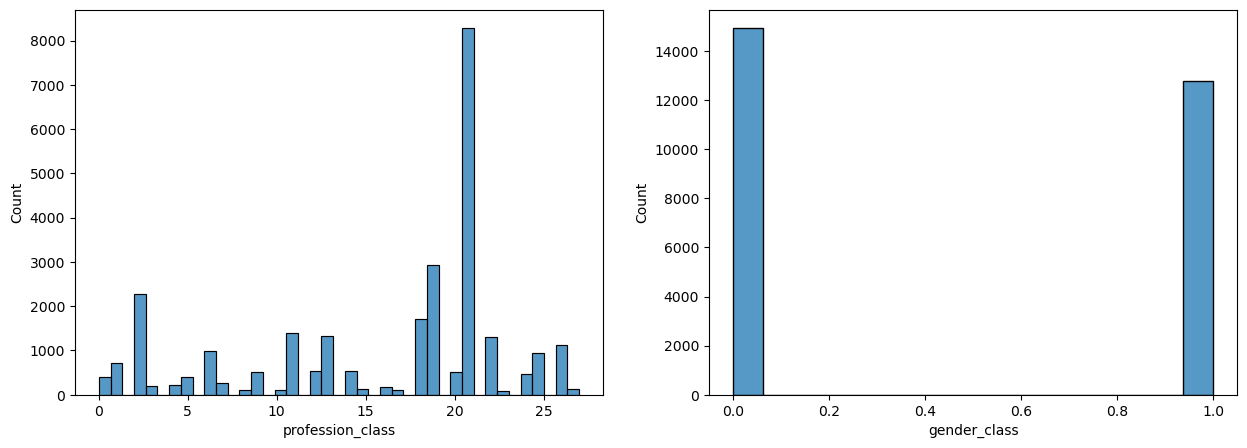

In [61]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(Y,) 
plt.subplot(1,2,2)
sns.histplot(S)

🕯️ As we can see, The classes are well unbalanced, along with the gender class. This could impact and bias our model, we should therefore try to remedy this. 

In [62]:
# Type of each column and number of missing values.
column_types = []

for col in X.columns:
    column_types.append(X[col].dtype)

print("Column types: ", set(column_types))
print("Number of missing values overall:", X.isnull().sum().sum())

Column types:  {dtype('float32')}
Number of missing values overall: 0


🕯️Let's have a look at the distribution :

d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='200', ylabel='Count'>

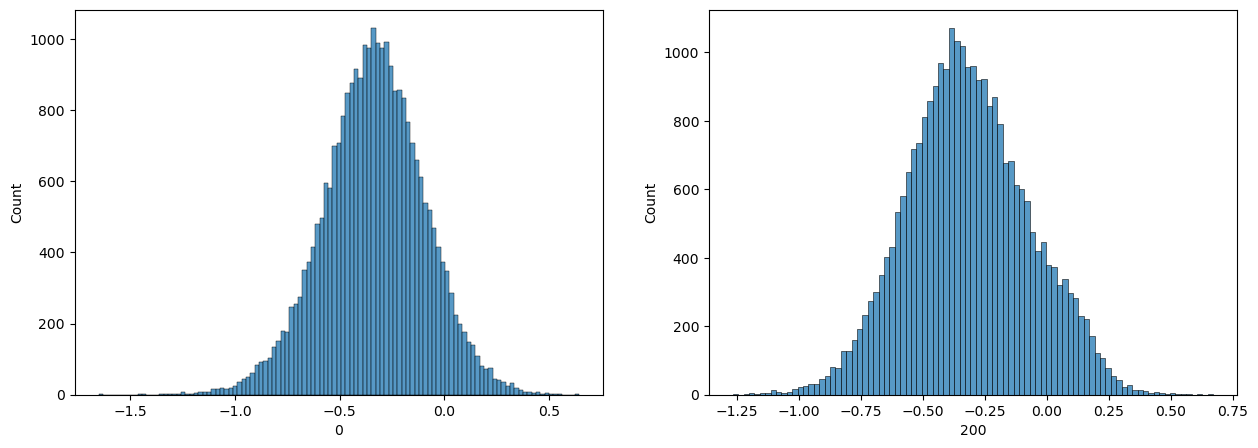

In [63]:
# Distribution of X
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(X.iloc[:,0])
plt.subplot(1,2,2)
sns.histplot(X.iloc[:,200])

In [64]:
# D'Agostino's K^2 Test for normality of X
normality_test = normaltest(X)

# Columns that are not normal
not_normal = []
for i in range(len(normality_test.pvalue)):
    if normality_test.pvalue[i] < 0.05:
        not_normal.append(i)
print("Number of columns that are not normal: ", len(not_normal))


Number of columns that are not normal:  736


In [65]:
# Unique std and mean range for each column
col_mean = []
col_std = []
for col in X.columns:
    col_std.append(X[col].std())
    col_mean.append(X[col].mean())

print(f"Mean range: [{min(col_mean)}, {max(col_mean)}]")
print(f"Std range: [{min(col_std)}, { max(col_std)}]")

Mean range: [-5.5552544593811035, 3.889770030975342]
Std range: [0.1805604100227356, 0.963977575302124]


## 2. Preprocessing

🚀 Let's normalize the data !  

In [66]:
# normalize X
scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X)

🚀 Now, let's use SMOTE to balance the classes. SMOTE will also increase the number of samples we have, which can be useful for deep learning.

X shape:  (27749, 769)


d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='gender_class', ylabel='Count'>

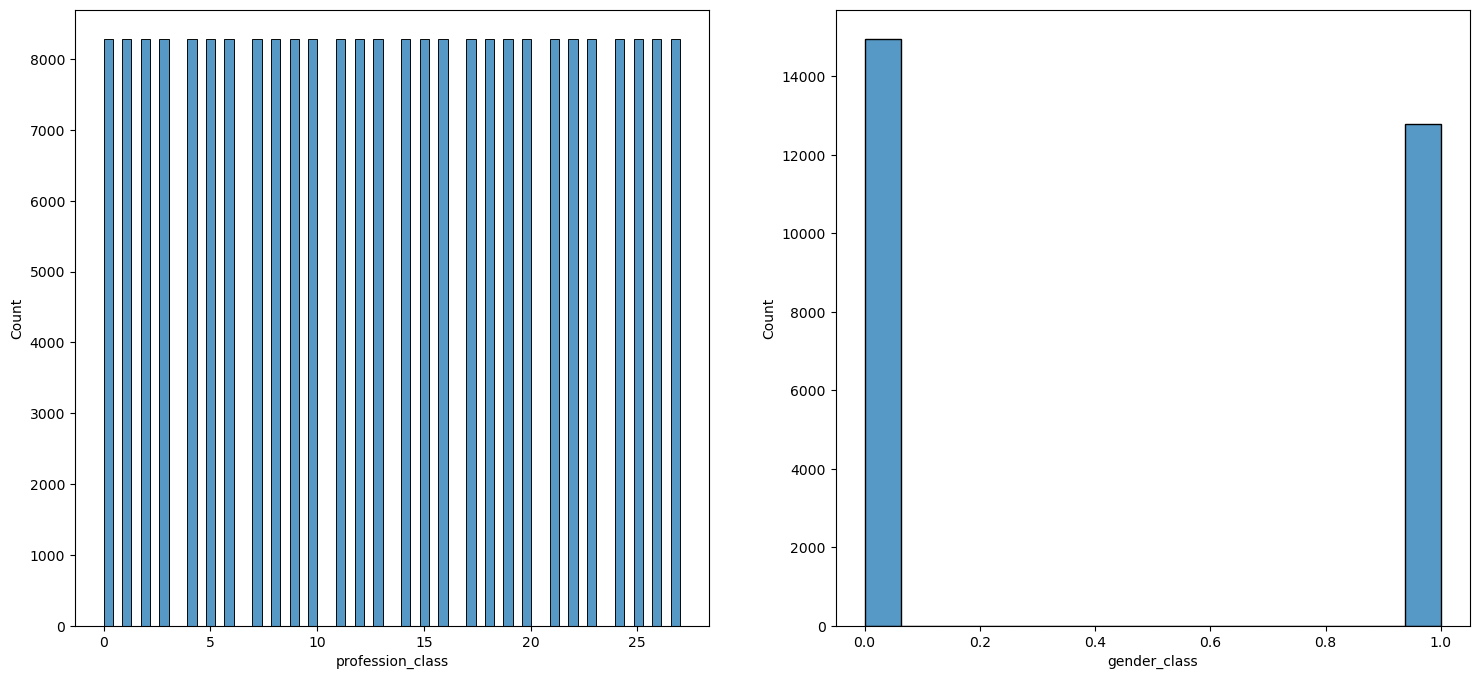

In [67]:
# balance classes with SMOTE
X_norm = np.concatenate((X_norm, S.values.reshape(-1,1)), axis=1)
print("X shape: ", X_norm.shape)
sm = SMOTE(random_state=random_state)
X_res, Y_res = sm.fit_resample(X_norm, Y)
S_res = X_res[:, -1]
X_res = X_res[:, :-1]
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.histplot(Y_res,)
plt.subplot(1,2,2)
sns.histplot(S)

d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\Anaconda\envs\ML_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='200', ylabel='Count'>

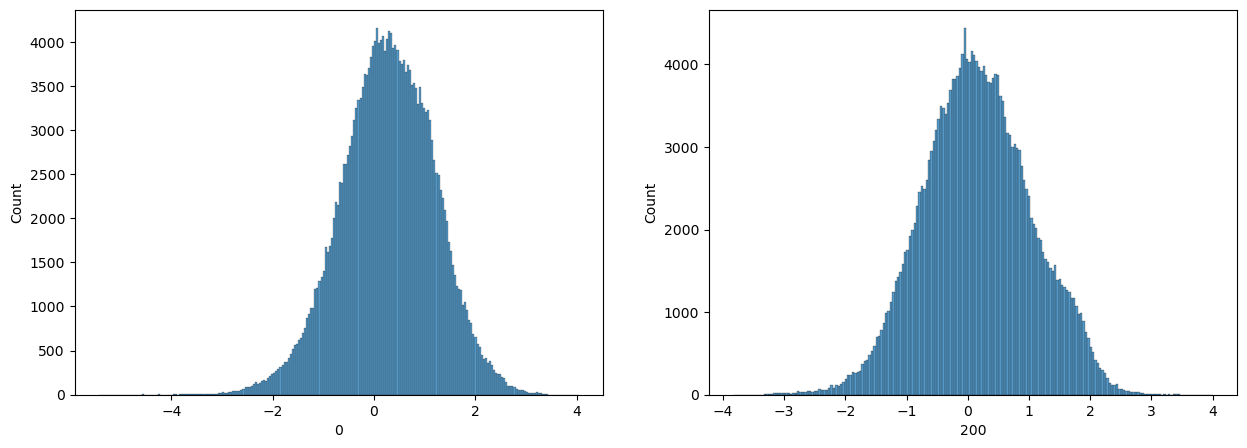

In [75]:
# distribution of X
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(pd.DataFrame(X_res).iloc[:,0])
plt.subplot(1,2,2)
sns.histplot(pd.DataFrame(X_res).iloc[:,200])


🕯️ Here we see the total number of sample on which we will train.

In [76]:
print(X_res.shape)

(231980, 768)


## 🤖 First model :

First the following model was tried in order to get a first idea of the task. Many architectures were tested and the number of neurons and layers adjusted until overfitting occured. Then regularization was added to the model.

In [81]:
X_train, X_val, Y_train, Y_val, S_train, S_val = train_test_split(X_res, Y_res, S_res, test_size=0.2, random_state=random_state)

In [78]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(768, 1024) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(1024, 28)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [80]:
def train_model(model, X, Y, epochs, lr, batch_size):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            inputs = X[i:i+batch_size]
            labels = Y[i:i+batch_size]
            inputs = torch.from_numpy(inputs).float()
            labels = torch.tensor(labels.values).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
    return model

mlflow.set_experiment('mlp')
mlp = MLP()
mlp = train_model(mlp, X_train, Y_train, 30, 0.001, 1000)

Epoch [1/30], Loss: 2.4594
Epoch [2/30], Loss: 2.4344
Epoch [3/30], Loss: 2.4210
Epoch [4/30], Loss: 2.4125
Epoch [5/30], Loss: 2.4072
Epoch [6/30], Loss: 2.4052
Epoch [7/30], Loss: 2.4044
Epoch [8/30], Loss: 2.4010
Epoch [9/30], Loss: 2.4006
Epoch [10/30], Loss: 2.4001
Epoch [11/30], Loss: 2.3992
Epoch [12/30], Loss: 2.4003
Epoch [13/30], Loss: 2.3990
Epoch [14/30], Loss: 2.3983
Epoch [15/30], Loss: 2.3986
Epoch [16/30], Loss: 2.3981
Epoch [17/30], Loss: 2.3963
Epoch [18/30], Loss: 2.3973
Epoch [19/30], Loss: 2.3985
Epoch [20/30], Loss: 2.3974
Epoch [21/30], Loss: 2.3972
Epoch [22/30], Loss: 2.3968
Epoch [23/30], Loss: 2.3982
Epoch [24/30], Loss: 2.3967
Epoch [25/30], Loss: 2.3980
Epoch [26/30], Loss: 2.3958
Epoch [27/30], Loss: 2.3971
Epoch [28/30], Loss: 2.3965
Epoch [29/30], Loss: 2.3958
Epoch [30/30], Loss: 2.3956


### Validation

In [ ]:
inputs = X_val
labels = Y_val
inputs = torch.tensor(inputs.values).float()
labels = torch.tensor(labels.values).long()
mlp.eval()
with torch.no_grad():
    outputs = mlp(inputs)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)
    print('Val Loss: {:.4f}'.format(loss.item()))
    eval_scores, confusion_matrices_eval = gap_eval_scores(outputs, labels, S_val, metrics=['TPR'])
    print(eval_scores)
    X_test = dat['X_test']
    X_test = (X_test - X_test.mean()) / X_test.std()
    inputs = X_test
    inputs = torch.tensor(inputs.values).float()
    pred = mlp(inputs)
    pred = pred.argmax(1)
    results=pd.DataFrame(pred, columns= ['score'])

### Submission : 

In [ ]:

X_test = dat['X_test']
Y_test = dat['Y_test']
S_test = dat['S_test']

with torch.no_grad():
    mlp.eval()
    X_test = (X_test - X_test.mean()) / X_test.std()
    inputs = X_test
    inputs = torch.tensor(inputs.values).float()
    pred = mlp(inputs)
    pred = pred.argmax(1)
    
eval_scores, confusion_matrices_eval = gap_eval_scores(pred, Y_test, S_test, metrics=['TPR'])

## ⚡Final model with pytorch lightning

The model was written in .py files, however every module is condensed here. Different losses were tested: crossentropy, Trotzky loss and a custom Fairness loss but the best score was obtained with the crossentropy.
A correlation remover function was also added to the preprocessing pipeline on top of the SMOTE and normalization to remove correlation between the sensitive attribute and the features

#### Preprocessing

In [1]:
def open_data(datapath):
    with open(datapath, 'rb') as handle:
        data = pd.read_pickle(handle)
        X_init = data['X_train']
        Y_init = data['Y']
        S_init = data['S_train']
        columns = data['X_train'].columns
        S_init_reset = S_init.reset_index(drop=True)
    return X_init, Y_init, S_init_reset, columns


def split_data(X: pd.DataFrame, Y, S, test_size=0.2):
    X_concat = pd.concat([X, S], axis=1)
    # rename the last column to 'gender_class'
    X_concat.columns = X_concat.columns.astype(str)
    X_concat.columns.values[-1] = 'gender_class'

    X_train, X_val, y_train, y_val = train_test_split(
        X_concat, Y, test_size=test_size, stratify=Y, random_state=42)
    return X_train, X_val, y_train, y_val


def remove_correlation(X_train, X_val):
    X_S_train = pd.DataFrame(X_train)
    X_S_train.columns = X_S_train.columns.astype(str)

    X_S_val = pd.DataFrame(X_val)
    X_S_val.columns = X_S_val.columns.astype(str)

    cr = CorrelationRemover(sensitive_feature_ids=["gender_class"])
    X_cr_train = cr.fit_transform(X_S_train)
    X_cr_train = pd.DataFrame(X_cr_train)
    X_cr_train.set_index(X_S_train.index, inplace=True)
    X_cr_train.loc[:, "gender_class"] = X_S_train.loc[:, "gender_class"]
    X_cr_val = cr.transform(X_S_val)
    X_cr_val = pd.DataFrame(X_cr_val)
    X_cr_val.set_index(X_S_val.index, inplace=True)
    X_cr_val.loc[:, "gender_class"] = X_S_val.loc[:, "gender_class"]
    S_train_cr = X_cr_train['gender_class']
    S_val_cr = X_cr_val['gender_class']

    X_cr_train.drop(columns='gender_class', inplace=True)
    X_cr_val.drop(columns='gender_class', inplace=True)
    return X_cr_train, X_cr_val, S_train_cr, S_val_cr


def balance_data(X, y, S):
    S = S.to_numpy().reshape(-1, 1)
    X = np.concatenate([X, S], axis=1)
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
    S = X[:, -1]
    X = X[:, :-1]
    return X, y, S


def norm(data, columns):
    scaler = StandardScaler().fit(data)
    X_pre = scaler.transform(data)
    X_pre = pd.DataFrame(X_pre, columns=columns)
    X_pre_reset = X_pre.reset_index(drop=True)
    return X_pre_reset, scaler


def preprocess_data(datapath, test_size=0.2):
    X_init, Y_init, S_init, columns = open_data(datapath)
    X_pre, scaler = norm(X_init, columns)

    X_train, X_val, y_train, y_val = split_data(
        X_pre, Y_init, S_init, test_size)

    X_cr_train, X_cr_val, S_train_cr, S_val_cr = remove_correlation(
        X_train, X_val)

    X_train, y_train, S_train = balance_data(X_cr_train, y_train, S_train_cr)

    return X_train, X_cr_val, y_train, y_val, S_train, S_val_cr, scaler


#### Dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, X, y, S, is_train=True):
        self.is_train = is_train
        if is_train:
            self.X = torch.tensor(X, dtype=torch.float32)
            self.y = torch.tensor(y, dtype=torch.long)
            self.S = torch.from_numpy(S).long()
        else:
            self.X = torch.tensor(X.values, dtype=torch.float32)
            self.y = torch.tensor(y.values, dtype=torch.long)
            self.S = torch.tensor(S.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.S[idx]


def create_datasets(datapath, test_size=0.2):
    X_train, X_val, y_train, y_val, S_train, S_val, scaler = preprocess_data(
        datapath, test_size=test_size)

    train_dataset = CustomDataset(
        X_train, y_train, S_train, is_train=True)

    val_dataset = CustomDataset(
        X_val, y_val, S_val, is_train=False)

    return train_dataset, val_dataset, scaler


#### Model

In [3]:
import torch
from torch import nn, optim
import torchmetrics
import pytorch_lightning as pl
from torch.nn.functional import softmax


class MLP(pl.LightningModule):
    def __init__(self, lr=0.01, batch_size=32, lambda_debias=0.01):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(768, 2048),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 28),
            nn.Softmax(dim=1)
        )
        self.lr = lr
        self.batch_size = batch_size
        self.loss_fn = nn.CrossEntropyLoss()
        self.lambda_debias = lambda_debias
        self.accuracy = torchmetrics.Accuracy('multiclass', num_classes=28)

    def forward(self, x):
        logits = self.MLP(x)
        return logits

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(), lr=self.lr)
        return optimizer

    def fairness_loss(self, outputs, sensitive_attrs):
        """Simple fairness loss based on differences in prediction distributions."""
        group_0_mask = sensitive_attrs == 0
        group_1_mask = sensitive_attrs == 1
        preds_0 = softmax(outputs[group_0_mask], dim=1).mean(dim=0)
        preds_1 = softmax(outputs[group_1_mask], dim=1).mean(dim=0)
        fairness_loss = torch.norm(
            preds_0 - preds_1, p=2)  # L2 norm as an example
        return fairness_loss

    def training_step(self, batch, batch_idx):
        # Assuming batch includes sensitive attributes
        inputs, labels, sensitive_attrs = batch
        outputs = self(inputs)
        # classification_loss = self.loss_fn(outputs, labels)
        # fairness_loss = self.fairness_loss(outputs, sensitive_attrs)
        loss = self.loss_fn(outputs, labels)
        self.accuracy(outputs, labels)
        self.log('train_loss', loss, on_step=False,
                 on_epoch=True, prog_bar=True)
        # self.log('fairness_loss', loss,
        #         on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', self.accuracy,
                 on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels, _ = batch  # Validation step unchanged; ignores sensitive attributes
        outputs = self(inputs)
        val_loss = self.loss_fn(outputs, labels)
        self.accuracy(outputs, labels)
        self.log('val_loss', val_loss, on_step=False,
                 on_epoch=True, prog_bar=True)
        self.log('val_accuracy', self.accuracy(outputs, labels),
                 on_step=False, on_epoch=True, prog_bar=True)
        return val_loss


#### Run model
*Please note that the displayed result is for one epoch only*
The variables chosen gave the best result.

In [10]:
torch.set_float32_matmul_precision('high')

###########################################
#                Variables                #
###########################################

datapath = "../data/data-challenge-student.pickle"
batch_size = 64
test_size = 0.2
lr = 1e-5
max_epochs = 100
num_workers = 0

###########################################


def train(batch_size=batch_size, lr=lr, max_epochs=max_epochs, num_workers=num_workers, datapath=datapath):

    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    mlflow.pytorch.autolog()
    # Prepare the data
    train_dataset, valid_dataset, scaler = create_datasets(
        datapath=datapath, test_size=test_size)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Initialize the model
    model = MLP(lr=lr, batch_size=batch_size)
    print(summary(model, torch.zeros(1, 768),
                  show_input=False, show_hierarchical=False))

    # Train the model.
    with mlflow.start_run():
        trainer = pl.Trainer(
            max_epochs=max_epochs,
            callbacks=[TQDMProgressBar(refresh_rate=20), EarlyStopping(monitor='val_loss', patience=10)],)

        trainer.fit(model, train_loader, valid_loader)

    return model, valid_loader, scaler


def test_model(model, val_loader):
    
    # test over the whole test set
    model.eval()
    all_preds = []
    all_labels = []
    all_bias = []
    for batch in val_loader:
        inputs, labels, bias = batch
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted)
        all_labels.append(labels)
        all_bias.append(bias)
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_bias = torch.cat(all_bias).cpu().numpy()

    eval_scores, _ = gap_eval_scores(
        all_preds, all_labels, all_bias, metrics=['TPR'])
    final_score = (eval_scores['macro_fscore'] + (1-eval_scores['TPR_GAP']))/2
    return print(f"Final score: {final_score}", f"\n Eval Scores: {eval_scores['macro_fscore']}", f"\n TPR_GAP: {eval_scores['TPR_GAP']}")


def submission(model, scaler, datapath=datapath):
    with open(datapath, 'rb') as handle:
        dat = pd.read_pickle(handle)
    X_test = dat['X_test']
    X_test = scaler.transform(X_test)

    inputs = X_test
    inputs = from_numpy(inputs).float()

    pred = model(inputs)
    pred = pred.argmax(1)

    results = pd.DataFrame(pred, columns=['score'])
    # random name for the submission file*
    random_number = random.randint(1, 100)
    results.to_csv(f"../outputs/Data_Challenge_MDI_341_{random_number}.csv",
                   header=None, index=None)


def main(batch_size=batch_size, lr=lr, max_epochs=max_epochs, num_workers=num_workers, datapath=datapath):

    # Scaler useful for the submission
    model, val_loader, scaler = train(
        batch_size, lr, max_epochs, num_workers, datapath)

    test_model(model, val_loader)
    submission(model, scaler, datapath)


if __name__ == "__main__":
    main(batch_size=batch_size, lr=lr, max_epochs=max_epochs, num_workers=num_workers,
         datapath=datapath)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
2024/03/21 19:26:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Anaconda\envs\ML_env\lib\site-packages\mlflow\pytorch\_lightning_autolog.py:463: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 1.4.9 and 2.2.0.post0 and may not succeed with packages outside this range."
Missing logger folder: a:\MSBGD\Data_Challenge\notebooks\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type           

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1           [1, 2048]       1,574,912       1,574,912
     BatchNorm1d-2           [1, 2048]           4,096           4,096
         Dropout-3           [1, 2048]               0               0
            ReLU-4           [1, 2048]               0               0
          Linear-5           [1, 1024]       2,098,176       2,098,176
     BatchNorm1d-6           [1, 1024]           2,048           2,048
         Dropout-7           [1, 1024]               0               0
            ReLU-8           [1, 1024]               0               0
          Linear-9             [1, 28]          28,700          28,700
        Softmax-10             [1, 28]               0               0
Total params: 3,707,932
Trainable params: 3,707,932
Non-trainable params: 0
-----------------------------------------------------------------------

d:\Anaconda\envs\ML_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
d:\Anaconda\envs\ML_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2900/2900 [00:10<00:00, 278.27it/s, v_num=0, val_loss=2.810, val_accuracy=0.640, train_loss=2.890, train_accuracy=0.591]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 2900/2900 [00:10<00:00, 268.51it/s, v_num=0, val_loss=2.810, val_accuracy=0.640, train_loss=2.890, train_accuracy=0.591]
Final score: 0.6751301001535052 
 Eval Scores: 0.48082598973842755 
 TPR_GAP: 0.13056578943141714
